In [ ]:
pip install tensorflow matplotlib


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time


In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

def preprocess_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])
    # Normalization to the range [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

def preprocess_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])
    # Normalization to the range [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image


In [ ]:
train_dataset = tf.data.Dataset.list_files('/content/drive/MyDrive/facades/train/*.jpg')
train_dataset = train_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.list_files('/content/drive/MyDrive/facades/test/*.jpg')
test_dataset = test_dataset.map(preprocess_image_test)
test_dataset = test_dataset.batch(1)

val_dataset = tf.data.Dataset.list_files('/content/drive/MyDrive/facades/val/*.jpg')
val_dataset = val_dataset.map(preprocess_image_test)
val_dataset = val_dataset.batch(1)


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')
    x = layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [ ]:
!ls /content/drive/MyDrive/facades/

test  train  val


In [ ]:
generator = Generator()
discriminator = Discriminator()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()
        for input_image, target in train_ds:
            train_step(input_image, target, epoch)
        print(f'Epoch {epoch+1} completed in {time.time()-start:.2f} seconds')

fit(train_dataset, epochs=13)


Epoch 1 completed in 37.55 seconds
Epoch 2 completed in 37.76 seconds
Epoch 3 completed in 38.38 seconds
Epoch 4 completed in 38.08 seconds
Epoch 5 completed in 37.48 seconds
Epoch 6 completed in 40.96 seconds
Epoch 7 completed in 37.93 seconds
Epoch 8 completed in 37.49 seconds
Epoch 9 completed in 37.31 seconds
Epoch 10 completed in 37.25 seconds
Epoch 11 completed in 37.24 seconds
Epoch 12 completed in 37.62 seconds
Epoch 13 completed in 37.26 seconds


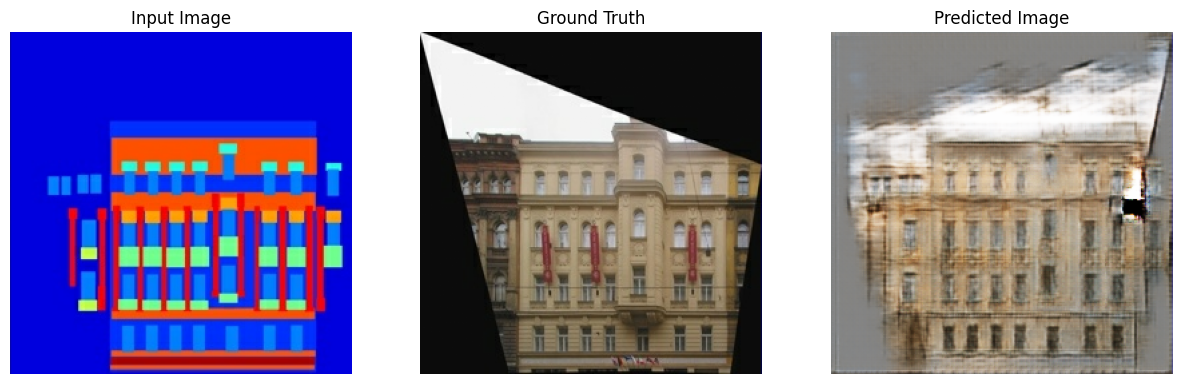

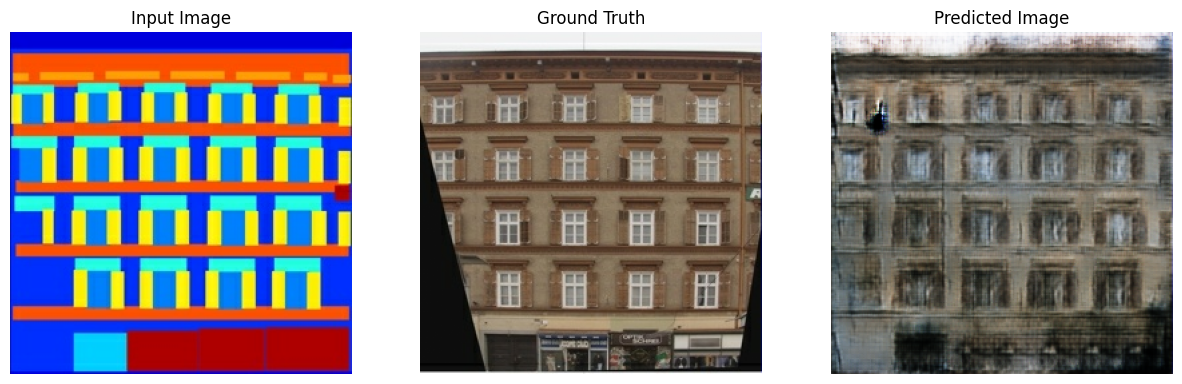

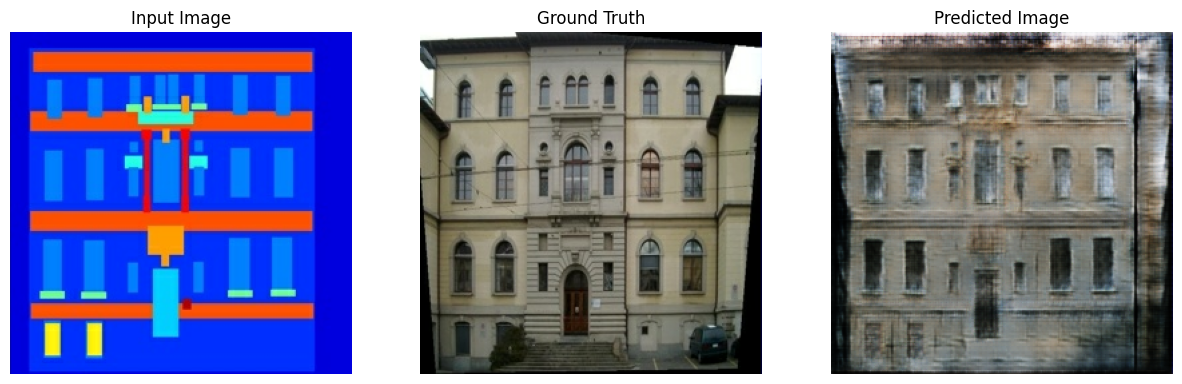

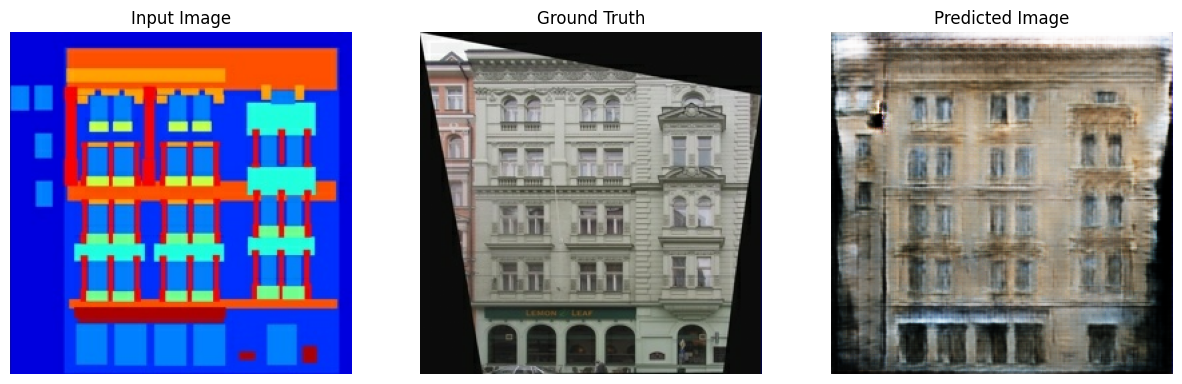

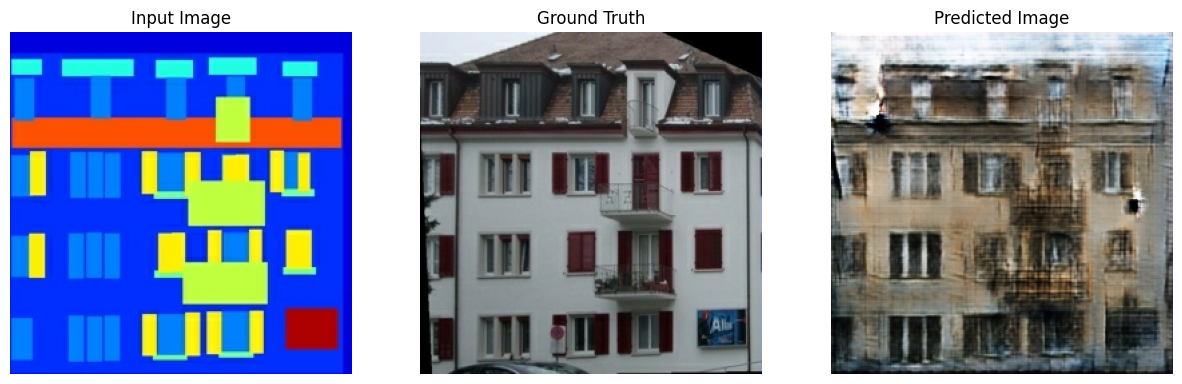

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)
